In [2]:
import pandas as pd
import os
import numpy as np
import string
import nltk
import re
import contractions
# import seaborn as sns

import gensim
import gensim.downloader
from gensim.models import Word2Vec
from gensim import utils


# from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, Softmax, Linear
from torch.optim import SGD, Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import warnings as wrn
wrn.filterwarnings('ignore')



Using TensorFlow backend.


In [4]:
#getting the data
data_file_path = './dataset'
file_list = os.listdir(data_file_path)

swda_df = pd.concat([pd.read_csv(data_file_path+'/'+f) for f in file_list ], ignore_index=True)

display(swda_df)

print("Shape of the Data : ", swda_df.shape)

,swda_filename,ptb_basename,conversation_no,transcript_index,act_tag,caller,utterance_index,subutterance_index,text,pos,trees,ptb_treenumbers
0,sw07utt/sw_0763_3402.utt,3/sw3402,3402,0,o,A,1,1,All right. /,All/RB right/JJ ./.,NaN,NaN
1,sw07utt/sw_0763_3402.utt,3/sw3402,3402,1,sd^t,A,1,2,I guess tonight's subject is to discuss curre...,I/PRP guess/VBP tonight/RB 's/POS subject/NN i...,NaN,NaN
2,sw07utt/sw_0763_3402.utt,3/sw3402,3402,2,aa,B,2,1,Right. /,Right/UH ./.,NaN,NaN
3,sw07utt/sw_0763_3402.utt,3/sw3402,3402,3,+,A,3,1,"-- satisfied [ with, + with ] the, {F uh } --","--/: satisfied/JJ with/IN ,/, with/IN the/DT ,...",NaN,NaN
4,sw07utt/sw_0763_3402.utt,3/sw3402,3402,4,%,B,4,1,"That's, -/","That/DT 's/BES ,/,",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
223601,sw02utt/sw_0259_2020.utt,2/sw2020,2020,264,%,B,134,6,I - /,[ I/PRP ],(S-UNF (NP-SBJ (PRP I)) (-DFL- N_S)),379
223602,sw02utt/sw_0259_2020.utt,2/sw2020,2020,265,%,B,134,7,"me, - /","[ me/PRP ] ,/,","(NP (PRP me) (, ,) (-DFL- N_S))",380
223603,sw02utt/sw_0259_2020.utt,2/sw2020,2020,266,sv,B,134,8,"{C and } you never would think [ that they, + ...",and/CC [ you/PRP ] never/RB would/MD think/VB...,(S (CC and) (NP-SBJ (PRP you)) (ADVP-TMP (RB n...,381
223604,sw02utt/sw_0259_2020.utt,2/sw2020,2020,267,%,B,134,9,"{C but, } -/","but/CC ,/,","(S-UNF (CC but) (, ,) (-DFL- N_S))",382


Shape of the Data :  (223606, 12)


In [5]:
#Adding binary is_classification column based on act_tag. 

#Experiment on POS, tree and ptb_treenumbers as a feature
parameters = ['utterance_index', 'subutterance_index', 'text', 'act_tag']
swda_df = swda_df[parameters]

# Creating a new column named is_backchannel
# Marking the column as 1 if act_tag is b else 0
is_backchannel = np.where(swda_df.act_tag == 'b', 1, 0)
swda_df['is_backchannel'] = is_backchannel

display(swda_df)


,utterance_index,subutterance_index,text,act_tag,is_backchannel
0,1,1,All right. /,o,0
1,1,2,I guess tonight's subject is to discuss curre...,sd^t,0
2,2,1,Right. /,aa,0
3,3,1,"-- satisfied [ with, + with ] the, {F uh } --",+,0
4,4,1,"That's, -/",%,0
...,...,...,...,...,...
223601,134,6,I - /,%,0
223602,134,7,"me, - /",%,0
223603,134,8,"{C and } you never would think [ that they, + ...",sv,0
223604,134,9,"{C but, } -/",%,0


In [6]:
#Preprocessing the data

#converting all the text to lower
swda_df['text'] = swda_df['text'].str.lower()

#Removing Punctuations
punctuation = string.punctuation
swda_df['text'] = swda_df['text'].apply(lambda x:' '.join(word for word in x.split() if word not in punctuation))

#punkt is a sentence tokenizer which converts the text into sentences and uses unsupervised learning for abbreviations
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/kaus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#Remove non-alphabetical character function by using regex
swda_df['text']=swda_df['text'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
swda_df['text']=swda_df['text'].apply(lambda x: re.sub(' +', ' ', x))
swda_df['text']=swda_df['text'].str.replace('\d+', '')

#Performing word contraction using library
swda_df['no_contract'] = swda_df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
swda_df['text'] = [' '.join(map(str, l)) for l in swda_df['no_contract']]
swda_df = swda_df.drop(['no_contract', 'act_tag'], axis='columns')
swda_df = swda_df.dropna()

display(swda_df)


,utterance_index,subutterance_index,text,is_backchannel
0,1,1,all right,0
1,1,2,i guess tonight s subject is to discuss curren...,0
2,2,1,right,0
3,3,1,satisfied with with the f uh,0
4,4,1,that s,0
...,...,...,...,...
223601,134,6,i,0
223602,134,7,me,0
223603,134,8,c and you never would think that they that the...,0
223604,134,9,c but,0


In [8]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(swda_df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))



Found 20696 unique tokens.


In [9]:
X = tokenizer.texts_to_sequences(swda_df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (223606, 250)


In [10]:
y = pd.get_dummies(swda_df['is_backchannel']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (223606, 2)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print("X_train : ", X_train)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


X_train :  [[  0   0   0 ... 139  28   6]
 [  0   0   0 ...  19   6 259]
 [  0   0   0 ...  10 709   8]
 ...
 [  0   0   0 ...   3   5 356]
 [  0   0   0 ...  13  42 216]
 [  0   0   0 ...   9  75 240]]
(201245, 250) (201245, 2)
(22361, 250) (22361, 2)


In [12]:
#LSTM

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


2023-04-06 19:59:49.065577: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 19:59:49.067373: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 181120 samples, validate on 20125 samples
Epoch 1/2
   320/181120 [..............................] - ETA: 1:06:35 - loss: 0.6745 - accuracy: 0.6906

KeyboardInterrupt: 

In [21]:
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


22361/22361 [==============================] - 226s 10ms/step
Test set
  Loss: 0.148
  Accuracy: 0.929


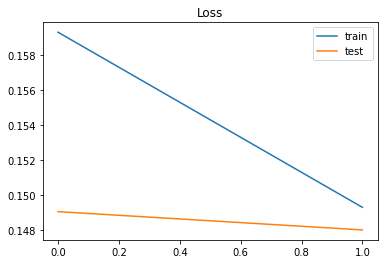

In [32]:
#Loss Graph
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

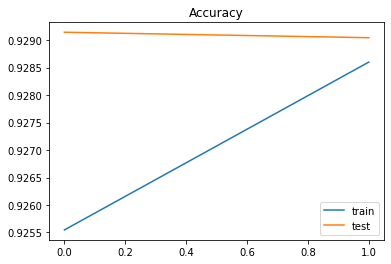

In [33]:
#Accuracy Graph
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [58]:
print(swda_df[swda_df['is_backchannel'] == 1])

        utterance_index  subutterance_index            text  is_backchannel
16                   11                   1           uhhuh               1
20                   13                   1           right               1
31                   19                   1           uhhuh               1
44                   29                   1            yeah               1
54                   32                   1           right               1
...                 ...                 ...             ...             ...
223581              127                   1  uhhuh laughter               1
223592              132                   1            yeah               1
223593              132                   2            okay               1
223596              134                   1            yeah               1
223605              135                   1       f oh yeah               1

[36180 rows x 4 columns]


In [1]:
new_complaint = ['yeah']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = [0,1]
print(pred, labels[np.argmax(pred)])


NameError: name 'tokenizer' is not defined